# Russian wikipedia network analysis

In [70]:
import pickle
import random
import graphviz
import matplotlib
import numpy as np

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

import networkx as nx
import seaborn as sns

In [108]:
GRAPH_PATH = './../saved_graphs/WIKI_2000.pkl'
with open(GRAPH_PATH, 'rb') as f:
    G = pickle.load(f)
G.remove_edges_from(nx.selfloop_edges(G))

# *SUMMARY*

### General info about our graph *`G`*

**1.1** Source - wikipedia pages

**1.2** Preprocessing steps

- `Select some start page of wikipedia (ex. https://ru.wikipedia.org/wiki/MapReduce)`

- `Add node to Graph`

- `Add current link to set of busy (added to graph) links`

- `Add links from page with substring "ru.wikipedia" to set of free links and to node attribute "neighbor_links"`

- `free links := (free links + links from current page) \ (busy links)`

- `Add directed edges for current node and already existed nodes if they have a connection with current node`

- `Randomly select page from set of free links`

- `Repeat 1.2 from second point N-1 times, N - num of nodes of generating graph`
    
**2.1** DiGraph is directed. Edge `(A, B)` - there is link on page `A` to page `B`. Edge `(B, A)` - there is link on page `B` to page `A`

**2.2** Graph is unweighted. All edges have the same weights, since the essence of each node is a wikipedia page and the analysis is carried out with the assumption that the "importance" of links is equivalent

**3.1** Node key - link to page. Each node has 2 attributes:

- `"name"` - title of Wiki page
- `"neighbor_links"` - links to other pages from curent page
    
**3.2** Edges don't have attributes

**4.1** DiGraph has `2000` nodes and `8195` edges and Graph with same nodes has `6321` edges 

In [109]:
print(G)

DiGraph with 2000 nodes and 8195 edges


In [110]:
c = random.randint(0, len(G.nodes)-1)
link = list(G.nodes.keys())[c]
G.nodes[link].keys()

dict_keys(['name', 'neighbor_links'])

In [111]:
def print_nodes(G, num_of_links=5, display_links=False):
    random_nodes10 = [random.choice(list(G.nodes.keys())) for _ in range(num_of_links)]
    for link in random_nodes10: print(G.nodes[link]['name'].split('—')[0][:-1], link*display_links)

In [112]:
print_nodes(G, num_of_links=5, display_links=False)

Вайденбаумталер 
Абу-ль-Хасан аль-Ашари 
Самооборона Республики Польша 
Гулябзой, Саид Мохаммад 
Рождество Пресвятой Богородицы 


### Radius and Diameter

Let us make not directed graph `G_not_directed` from directed graph `G`

In [113]:
G_not_directed = nx.Graph(G)

In [114]:
print(G_not_directed)

Graph with 2000 nodes and 6321 edges


In [9]:
def get_radius_and_diameter(G):
    return nx.radius(G), nx.diameter(G)

In [10]:
get_radius_and_diameter(G_not_directed)

(6, 11)

### Clustering

In [11]:
def average_clustering(G):
    return np.array(list(nx.clustering(G).values()))

Global clustering coefficient: 0.26938762079871015


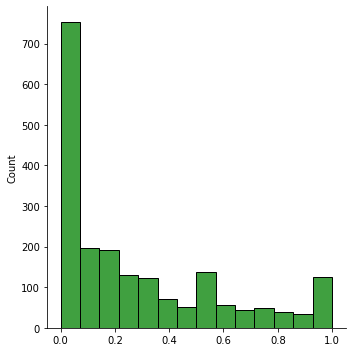

In [12]:
# Histogram of clustering coef for each node
arr = average_clustering(G)
print('Global clustering coefficient:', np.mean(arr))
sns.displot(arr, color='g');

### Average path length

In [13]:
def average_path_lengths(G):
    res = []
    for _, node_lengths in nx.shortest_path_length(G):
        res.append(np.mean(list(node_lengths.values())))
    return res

Global shortest path:  4.658412837100052


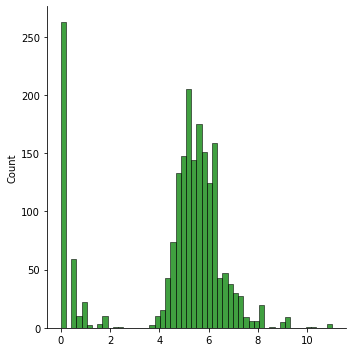

In [14]:
# Histogram of average path length for each node
arr = average_path_lengths(G)
print('Global shortest path: ', np.mean(arr))

fig = sns.displot(arr, color='g');

### Degree distribution

In [187]:
def get_degrees(G):
    res = [degree for _, degree in nx.degree(G)]
    return np.array(res)

Mean node degree:  8.195


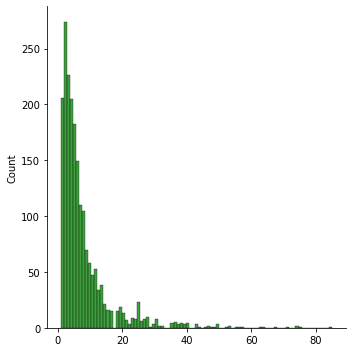

In [209]:
# Histogram of node degrees
arr = np.sort(get_degrees(G))
print('Mean node degree: ', np.mean(arr))

sns.displot(arr[:-5], color='g');

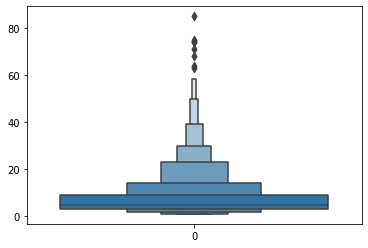

In [211]:
sns.boxenplot(data=arr[:-5]);

### Network layout

In [138]:
def make_random_subgraph(G, n):
    return nx.subgraph(G, random.sample(list(G.nodes), n))

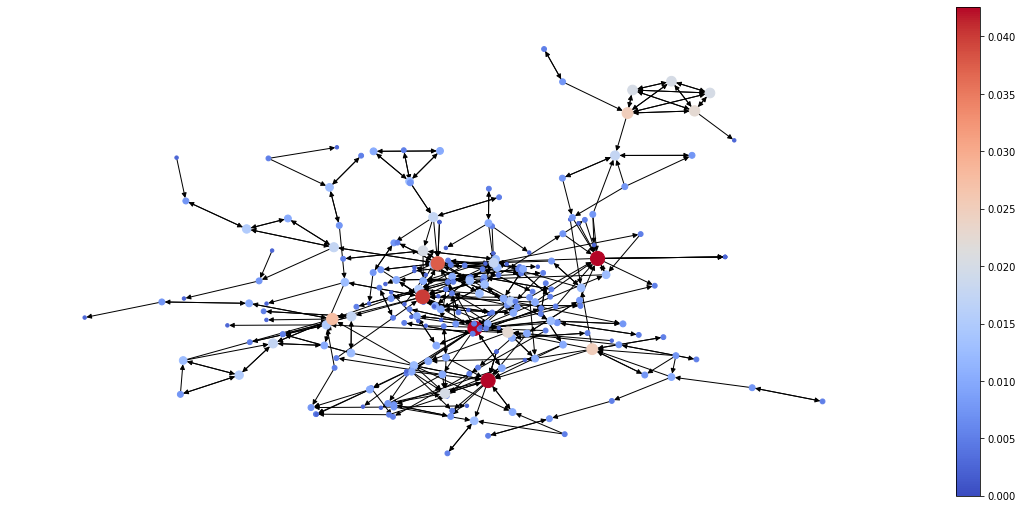

In [140]:
G_sub = make_random_subgraph(G, 400)
plt.figure(figsize=(20,9))

deg_centrality = nx.degree_centrality(G_sub)
cent = np.fromiter(deg_centrality.values(), float)
sizes = cent / np.max(cent) * 200
normalize = mcolors.Normalize(vmin=cent.min(), vmax=cent.max())
colormap = cm.coolwarm

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(cent)
plt.colorbar(scalarmappaple)

pos = nx.kamada_kawai_layout(G_sub)
nx.draw(G_sub, pos, node_size=sizes, node_color=sizes, cmap=colormap)
plt.show()

# ***Structural Analysis***

### The closest random graph model similar to network

In [185]:
def get_graph_stats(G):
    stats = {}
    stats['radius'] = nx.radius(G)
    stats['diameter'] = nx.diameter(G)
    stats['average_clst'] = nx.average_clustering(G)
    stats['average_path'] = nx.average_shortest_path_length(G)
    stats['num_of_cc'] = len(list(nx.connected_components(G)))
    return stats

In [218]:
# Our graph
stats = get_graph_stats(G_not_directed)
degrees_orig = np.sort(get_degrees(G_not_directed))
print('Radius:', stats['radius'])
print('Diameter:', stats['diameter'])
print('Average clustering:', stats['average_clst'])
print('Average shortest path length:', stats['average_path'])
print('Num of connected components:', stats['num_of_cc'])

Radius: 6
Diameter: 11
Average clustering: 0.3335020246259195
Average shortest path length: 3.920136068034017
Num of connected components: 1


In [219]:
# Barabasi-Albert graph
G_ba = nx.barabasi_albert_graph(n=2000, m=round(np.mean(get_degrees(G_not_directed))))
degrees_ba = np.sort(get_degrees(G_ba))
stats = get_graph_stats(G_ba)
print('Radius:', stats['radius'])
print('Diameter:', stats['diameter'])
print('Average clustering:', stats['average_clst'])
print('Average shortest path length:', stats['average_path'])
print('Num of connected components:', stats['num_of_cc'])

Radius: 3
Diameter: 5
Average clustering: 0.02474510538672643
Average shortest path length: 3.042590795397699
Num of connected components: 1


In [285]:
# Wattz-Strogatz graph
G_ws = nx.watts_strogatz_graph(n=2000, k=3, p=0.5)
degrees_ws = np.sort(get_degrees(G_ws))
stats = get_graph_stats(G_ws)
print('Radius:', stats['radius'])
print('Diameter:', stats['diameter'])
print('Average clustering:', stats['average_clst'])
print('Average shortest path length:', stats['average_path'])
print('Num of connected components:', stats['num_of_cc'])

Radius: 68
Diameter: 136
Average clustering: 0.0
Average shortest path length: 50.95452326163082
Num of connected components: 1


In [224]:
# Erdos-Renyi graph
G_er = nx.erdos_renyi_graph(n=2000, p=len(G_not_directed.nodes)/len(G_not_directed.edges))
degrees_er = np.sort(get_degrees(G_er))
stats = get_graph_stats(G_er)
print('Radius:', stats['radius'])
print('Diameter:', stats['diameter'])
print('Average clustering:', stats['average_clst'])
print('Average shortest path length:', stats['average_path'])
print('Num of connected components:', stats['num_of_cc'])

Radius: 2
Diameter: 2
Average clustering: 0.3164236321609571
Average shortest path length: 1.6835637818909455
Num of connected components: 1


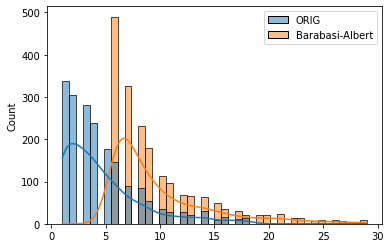

In [294]:
import pandas as pd

data = pd.DataFrame(data={'ORIG' : degrees_orig[:-100],
                          'Barabasi-Albert' : degrees_ba[:-100]})
sns.histplot(data, kde=True);

### Top centralities

In [391]:
def get_top_centrality(G, centrality_function, hubs=0):
    l, res = [],[]
    d = centrality_function(G)
    if type(d)==tuple:
        d = d[hubs]
    for link in d.keys():
        l.append((link, d[link]))
    l.sort(key=lambda x: x[1])
    for link, val in l[-5:]:
        res.append((G.nodes[link]['name'], val, link))
    return res[::-1]

In [375]:
top_closeness = get_top_centrality(G, nx.closeness_centrality)
c=1
for name, value, link in top_closeness:
    print(f'#{c}: {name}')
    print(f'Closeness centrality: {value}')
    print(link)
    print('-'*50)
    c+=1

#1: VIAF — Википедия
Closeness centrality: 0.375702728099669
https://ru.wikipedia.org/wiki/VIAF
--------------------------------------------------
#2: Национальная библиотека Чешской Республики — Википедия
Closeness centrality: 0.344915433783489
https://ru.wikipedia.org/wiki/%D0%9D%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D0%B1%D0%B8%D0%B1%D0%BB%D0%B8%D0%BE%D1%82%D0%B5%D0%BA%D0%B0_%D0%A7%D0%B5%D1%88%D1%81%D0%BA%D0%BE%D0%B9_%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8
--------------------------------------------------
#3: Казахстан — Википедия
Closeness centrality: 0.28605284303424633
https://ru.wikipedia.org/wiki/%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD
--------------------------------------------------
#4: Варшава — Википедия
Closeness centrality: 0.2820967930773897
https://ru.wikipedia.org/wiki/%D0%92%D0%B0%D1%80%D1%88%D0%B0%D0%B2%D0%B0
--------------------------------------------------
#5: Столица — Википедия
Closeness centrali

In [376]:
top_betweenness = get_top_centrality(G, nx.betweenness_centrality)
c=1
for name, value, link in top_betweenness:
    print(f'#{c}: {name}')
    print(f'Betweenness centrality: {value}')
    print(link)
    print('-'*50)
    c+=1

#1: Казахстан — Википедия
Betweenness centrality: 0.16200740574079586
https://ru.wikipedia.org/wiki/%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD
--------------------------------------------------
#2: Варшава — Википедия
Betweenness centrality: 0.13407427586717535
https://ru.wikipedia.org/wiki/%D0%92%D0%B0%D1%80%D1%88%D0%B0%D0%B2%D0%B0
--------------------------------------------------
#3: VIAF — Википедия
Betweenness centrality: 0.11293818409645316
https://ru.wikipedia.org/wiki/VIAF
--------------------------------------------------
#4: 2005 год — Википедия
Betweenness centrality: 0.09451741128137832
https://ru.wikipedia.org/wiki/2005
--------------------------------------------------
#5: Россия — Википедия
Betweenness centrality: 0.07532846387534572
https://ru.wikipedia.org/wiki/%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B9%D1%81%D0%BA%D0%B0%D1%8F_%D0%A4%D0%B5%D0%B4%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F
--------------------------------------------------


In [379]:
top_katz = get_top_centrality(make_random_subgraph(G, 1000), nx.katz_centrality)
c=1
for name, value, link in top_katz:
    print(f'#{c}: {name}')
    print(f'Katz centrality: {value}')
    print(link)
    print('-'*50)
    c+=1

#1: VIAF — Википедия
Katz centrality: 0.4988418141135905
https://ru.wikipedia.org/wiki/VIAF
--------------------------------------------------
#2: 1895 год — Википедия
Katz centrality: 0.13987759114916817
https://ru.wikipedia.org/wiki/1895_%D0%B3%D0%BE%D0%B4
--------------------------------------------------
#3: 23 августа — Википедия
Katz centrality: 0.12893936050130475
https://ru.wikipedia.org/wiki/23_%D0%B0%D0%B2%D0%B3%D1%83%D1%81%D1%82%D0%B0
--------------------------------------------------
#4: Варшава — Википедия
Katz centrality: 0.12475331701276669
https://ru.wikipedia.org/wiki/%D0%92%D0%B0%D1%80%D1%88%D0%B0%D0%B2%D0%B0
--------------------------------------------------
#5: 1988 год — Википедия
Katz centrality: 0.11661838163246657
https://ru.wikipedia.org/wiki/1988_%D0%B3%D0%BE%D0%B4
--------------------------------------------------


In [380]:
top_eigenvector = get_top_centrality(G, nx.eigenvector_centrality)
c=1
for name, value, link in top_eigenvector:
    print(f'#{c}: {name}')
    print(f'Eigenvector centrality: {value}')
    print(link)
    print('-'*50)
    c+=1

#1: 1895 год — Википедия
Eigenvector centrality: 0.2425573037729064
https://ru.wikipedia.org/wiki/1895_%D0%B3%D0%BE%D0%B4
--------------------------------------------------
#2: 1905 год — Википедия
Eigenvector centrality: 0.23979059215677812
https://ru.wikipedia.org/wiki/1905_%D0%B3%D0%BE%D0%B4
--------------------------------------------------
#3: 1908 год — Википедия
Eigenvector centrality: 0.2392352391350995
https://ru.wikipedia.org/wiki/1908_%D0%B3%D0%BE%D0%B4
--------------------------------------------------
#4: VIAF — Википедия
Eigenvector centrality: 0.23010091370270402
https://ru.wikipedia.org/wiki/VIAF
--------------------------------------------------
#5: 1972 год — Википедия
Eigenvector centrality: 0.2036038793464603
https://ru.wikipedia.org/wiki/1972_%D0%B3%D0%BE%D0%B4
--------------------------------------------------


In [381]:
top_pagerank = get_top_centrality(G, nx.pagerank)
c=1
for name, value, link in top_pagerank:
    print(f'#{c}: {name}')
    print(f'PageRank score: {value}')
    print(link)
    print('-'*50)
    c+=1

#1: VIAF — Википедия
PageRank score: 0.06187482094776132
https://ru.wikipedia.org/wiki/VIAF
--------------------------------------------------
#2: Национальная библиотека Чешской Республики — Википедия
PageRank score: 0.05343147881121338
https://ru.wikipedia.org/wiki/%D0%9D%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D0%B1%D0%B8%D0%B1%D0%BB%D0%B8%D0%BE%D1%82%D0%B5%D0%BA%D0%B0_%D0%A7%D0%B5%D1%88%D1%81%D0%BA%D0%BE%D0%B9_%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8
--------------------------------------------------
#3: Варшава — Википедия
PageRank score: 0.03259812329445651
https://ru.wikipedia.org/wiki/%D0%92%D0%B0%D1%80%D1%88%D0%B0%D0%B2%D0%B0
--------------------------------------------------
#4: Лихтенштейнская государственная библиотека — Википедия
PageRank score: 0.02280495477311054
https://ru.wikipedia.org/wiki/%D0%9B%D0%B8%D1%85%D1%82%D0%B5%D0%BD%D1%88%D1%82%D0%B5%D0%B9%D0%BD%D1%81%D0%BA%D0%B0%D1%8F_%D0%B3%D0%BE%D1%81%D1%83%D0%B4%D0%B0%D1%80%

In [395]:
top_hits_hubs = get_top_centrality(G, nx.hits, 0)
c=1
for name, value, link in top_hits_hubs:
    print(f'#{c}: {name}')
    print(f'PageRank score: {value}')
    print(link)
    print('-'*50)
    c+=1

#1: Россия — Википедия
PageRank score: 0.0037566722217781076
https://ru.wikipedia.org/wiki/%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B9%D1%81%D0%BA%D0%B0%D1%8F_%D0%A4%D0%B5%D0%B4%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F
--------------------------------------------------
#2: Союз Советских Социалистических Республик — Википедия
PageRank score: 0.0033131384944123034
https://ru.wikipedia.org/wiki/%D0%A1%D0%BE%D0%B2%D0%B5%D1%82%D1%81%D0%BA%D0%B8%D0%B9_%D0%A1%D0%BE%D1%8E%D0%B7
--------------------------------------------------
#3: Германия — Википедия
PageRank score: 0.0032147745495289463
https://ru.wikipedia.org/wiki/%D0%A4%D0%A0%D0%93
--------------------------------------------------
#4: Казахстан — Википедия
PageRank score: 0.0032146159218564754
https://ru.wikipedia.org/wiki/%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD
--------------------------------------------------
#5: Иран — Википедия
PageRank score: 0.0031953995074056655
https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D1%81%D0%B8%D1

In [396]:
top_hits_hubs = get_top_centrality(G, nx.hits, 1)
c=1
for name, value, link in top_hits_hubs:
    print(f'#{c}: {name}')
    print(f'PageRank score: {value}')
    print(link)
    print('-'*50)
    c+=1

#1: VIAF — Википедия
PageRank score: 0.12678305359970032
https://ru.wikipedia.org/wiki/VIAF
--------------------------------------------------
#2: Национальная библиотека Чешской Республики — Википедия
PageRank score: 0.09131414316888006
https://ru.wikipedia.org/wiki/%D0%9D%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D0%B1%D0%B8%D0%B1%D0%BB%D0%B8%D0%BE%D1%82%D0%B5%D0%BA%D0%B0_%D0%A7%D0%B5%D1%88%D1%81%D0%BA%D0%BE%D0%B9_%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8
--------------------------------------------------
#3: Казахстан — Википедия
PageRank score: 0.012767851596358844
https://ru.wikipedia.org/wiki/%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD
--------------------------------------------------
#4: Столица — Википедия
PageRank score: 0.010096838511020494
https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%BE%D0%BB%D0%B8%D1%86%D0%B0
--------------------------------------------------
#5: Первый канал (Россия) — Википедия
PageRank score: 0.008

### Correlation between centralities

In [492]:
G_sub = make_random_subgraph(G, 1000)
df = pd.DataFrame({'Closeness' : list(nx.closeness_centrality(G_sub).values()),
                   'Betwenness' : list(nx.betweenness_centrality(G_sub).values()),
                   'Katz' : list(nx.katz_centrality(G_sub).values()),
                   'Eigen' : list(nx.eigenvector_centrality(G_sub).values())
                  })

In [494]:
df.corr()

,Closeness,Betwenness,Katz,Eigen
Closeness,1.000000,0.348726,0.541646,0.141816
Betwenness,0.348726,1.000000,0.768714,0.067546
Katz,0.541646,0.768714,1.000000,0.327918
Eigen,0.141816,0.067546,0.327918,1.000000


In [1]:
from sklearn.metrics.pairwise import cosine_similarity

def sim_matrices(G):
    match = dict(zip(list(G.nodes), np.arange(len(G.nodes))))
    A = nx.adjacency_matrix(G).toarray()
    corr = np.corrcoef(A)
    
    J = np.diag(np.diag(np.ones((len(G.nodes), len(G.nodes)))))
    for u, v, sim_j in nx.jaccard_coefficient(G):
        J[match[u]][match[v]] = int(sim_j)

    cos = cosine_similarity(A)
            
    return A, corr, J, cos

In [ ]:
A, corr, J, cos = sim_matrices(G_not_directed)

### Clique and k-cores

In [477]:
def make_max_clique_graph(G):
    max_clique = []
    for clique in list(nx.find_cliques(G)):
        if len(max_clique)<len(clique):
            max_clique = clique
    return nx.subgraph(G, max_clique)

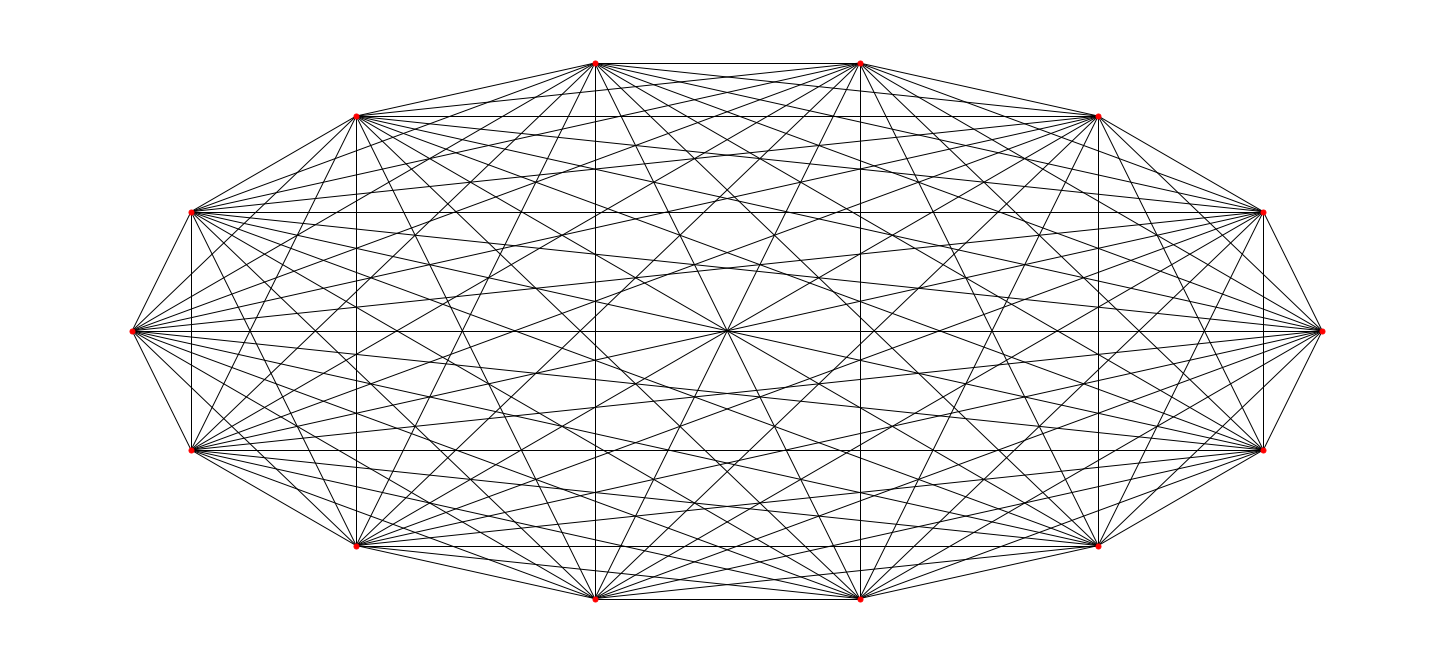

In [478]:
G_max_clique = make_max_clique_graph(G_not_directed)

plt.figure(figsize=(20,9))
pos = nx.kamada_kawai_layout(G_cliques)
nx.draw(G_max_clique, pos=pos, node_size=25, node_color='r',)
plt.show()

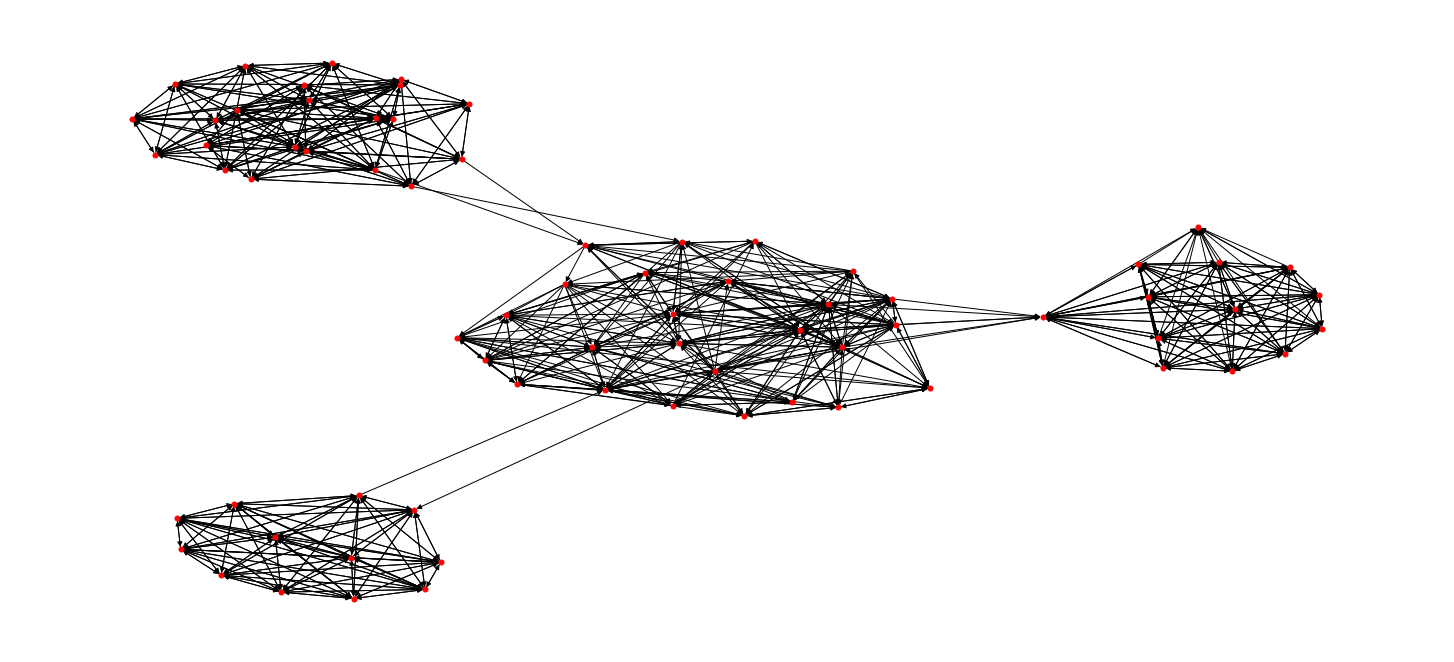

In [445]:
G_k_core = nx.k_core(G, k=15)

plt.figure(figsize=(20,9))
pos=nx.kamada_kawai_layout(G_k_core)
nx.draw(G_k_core, pos=pos, node_size=25, node_color='r',)
plt.show()